# 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import my_functions as mf

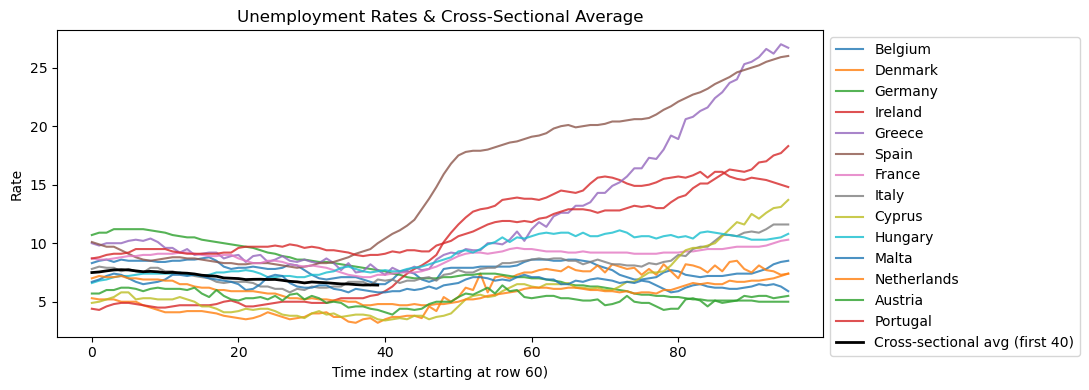

In [5]:


df = pd.read_csv('Unemp_Rate.csv').drop(columns=['TIME'])
df2 = df.iloc[60:].reset_index(drop=True)   
avg40 = df2.iloc[:40].mean(axis=1)

X = sm.add_constant(avg40)
betas = []
for col in df2.columns:
    y40 = df2[col].iloc[:40]
    model = sm.OLS(y40, X).fit()
    betas.append(model.params[1:])        
    
betas = np.round(np.array(betas), 3)           
# print("Betas:", betas)
# print("Shape:", betas.shape)

plt.figure(figsize=(11,4))

for col in df2.columns:
    plt.plot(df2.index, df2[col], alpha=0.8, label=col)
plt.plot(
    avg40.index, avg40,
    color='black', lw=2,
    label='Cross‐sectional avg (first 40)'
)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Unemployment Rates & Cross-Sectional Average")
plt.xlabel("Time index (starting at row 60)")
plt.ylabel("Rate")
plt.tight_layout()
plt.show()

In [9]:
df = df2.copy()

In [18]:
df = np.array(df)
Y = df[:40, 0]
X = df[:40, 1:]
X_const = sm.add_constant(X)
model = sm.OLS(Y, X_const)
results = model.fit()
params = results.params
a = params[0]  # Intercept
b = params[1:] # All slopes
pre_resid = Y - (a + X @ b)
Y = df[40:, 0]
X = df[40:, 1:]
post_resid = Y - (a + X @ b)


Running Simulations: |██████████████████████████████| 100% --- 100/100

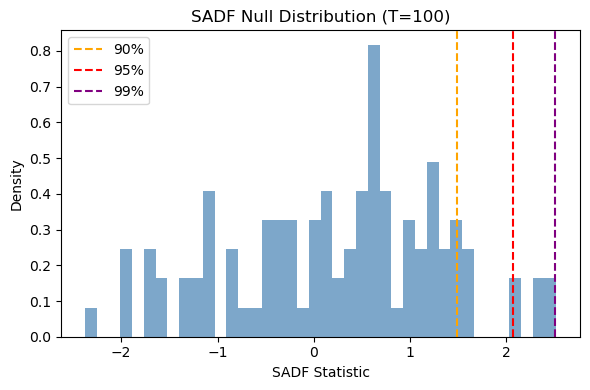

     Critical Value
90%        1.483603
95%        2.070191
99%        2.503037




In [23]:
num_series = 14
z = mf.random_walk(1000).reshape(-1, 1) #constant
eps = np.random.normal(0, 1, size=(1000, num_series)) # DEPENDS on T
et = np.random.normal(0, 1, size=(1000, num_series)) #constant

B = 100
multipliers = betas.squeeze()

T = 100
e = eps[:T,:].copy()
common_fac = z[:T].copy()

num_of_rw = 0.6
coint_frac = 0.4
innov_8 = np.random.normal(0, 1, size=(T - int(T * coint_frac), int(num_of_rw * num_series))) #constant

innov = innov_8
crit_val = mf.simulate_sadf_distribution_gpu(B=B, T=T, num_series=num_series, coint_frac=coint_frac, num_of_rw=num_of_rw, multi = multipliers)
print(crit_val)
crit_val_95 = np.round(crit_val.loc["95%", "Critical Value"],3)
crit_val_99 = np.round(crit_val.loc["99%", "Critical Value"],3)

print("\n")

# """ Run Experiment """
# mf.run_sadf_bubble_check( delta, T, coint_frac, num_of_rw,  common_fac, multipliers, innov, e, crit_val_95, crit_val_99, num_series)
# print("Multipliers:", multipliers)

Running Simulations: |██████████████████████████████| 100% --- 100/100

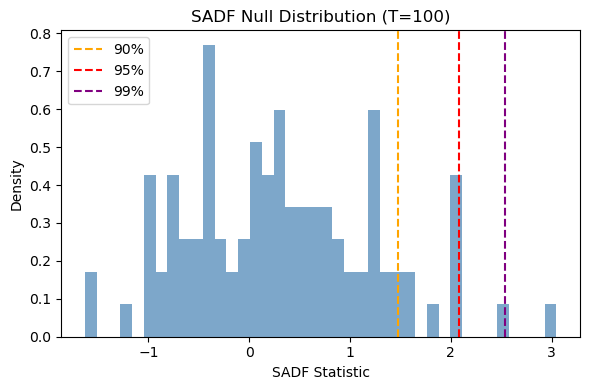

     Critical Value
90%        1.480219
95%        2.084173
99%        2.535594




In [24]:
num_series = 14
z = mf.random_walk(1000).reshape(-1, 1) #constant
eps = np.random.normal(0, 1, size=(1000, num_series)) # DEPENDS on T
et = np.random.normal(0, 1, size=(1000, num_series)) #constant


T = 100
e = eps[:T,:].copy()
common_fac = z[:T].copy()

num_of_rw = 0.4
coint_frac = 0.4
innov_8 = np.random.normal(0, 1, size=(T - int(T * coint_frac), int(num_of_rw * num_series))) #constant

crit_val = mf.simulate_sadf_distribution_gpu(B=B, T=T, num_series=num_series, coint_frac=coint_frac, num_of_rw=num_of_rw, multi = multipliers)
print(crit_val)
crit_val_95_40 = np.round(crit_val.loc["95%", "Critical Value"],3)
crit_val_99_40 = np.round(crit_val.loc["99%", "Critical Value"],3)

print("\n")



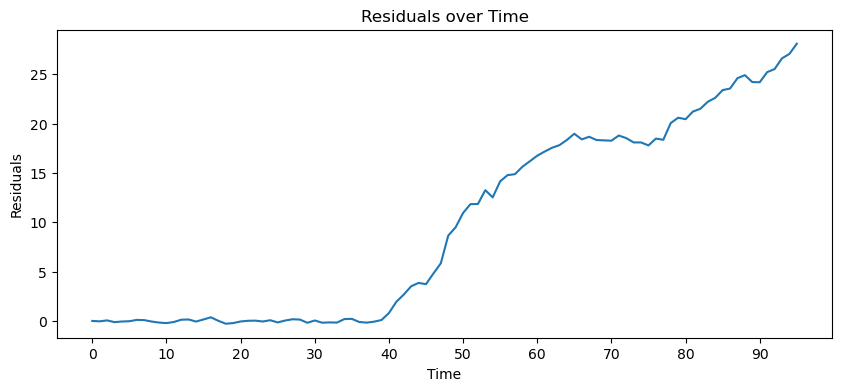

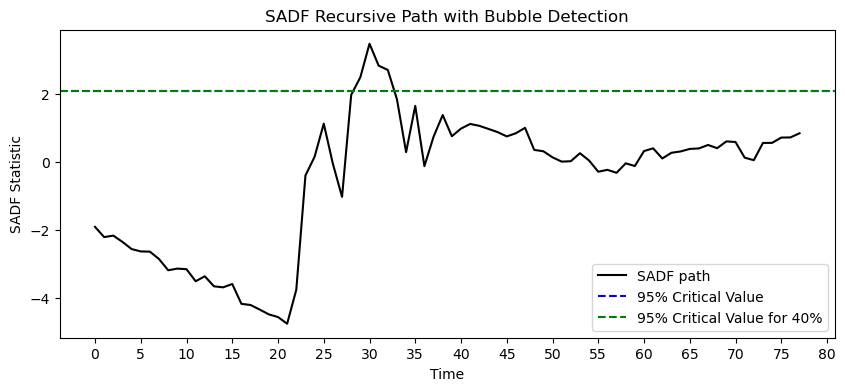

In [29]:
resid = np.concatenate([pre_resid,post_resid])
plt.figure(figsize=(10, 4))
plt.plot(resid)
plt.title("Residuals over Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
# Increase number of x-ticks for the residuals plot
plt.locator_params(axis='x', nbins=20)
plt.show()

# Calculate minimum window and SADF series
min_win = int((0.01 + 1.8 / np.sqrt(T)) * T)
sadf_stats = mf.sadf_series(resid, min_win)

# Plot SADF path with shaded bubble window
plt.figure(figsize=(10, 4))
plt.plot(sadf_stats, label='SADF path', color='black')
plt.axhline(crit_val_95, color='blue', linestyle='--', label='95% Critical Value')
#plt.axhline(crit_val_99, color='red', linestyle='--', label='99% Critical Value')
plt.axhline(crit_val_95_40, color='green', linestyle='--', label='95% Critical Value for 40%')
#plt.axhline(crit_val_99_40, color='magenta', linestyle='--', label='99% Critical Value for 40%')

# Highlight the window where the statistic first exceeds the 95% critical value
for t, stat in enumerate(sadf_stats):
    if stat > crit_val_95:
        start = t-1
        end = t + min_win
        # plt.axvspan(start, end, color='orange', alpha=0.3, label='Bubble window')
        break

plt.title("SADF Recursive Path with Bubble Detection")
plt.xlabel("Time")
plt.ylabel("SADF Statistic")
plt.legend()
# Increase number of x-ticks for better readability
plt.locator_params(axis='x', nbins=20)
plt.show()


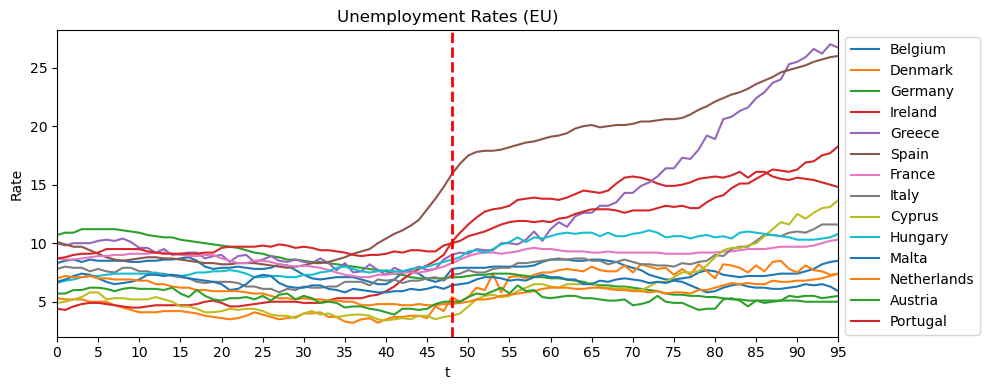

In [31]:
df = pd.read_csv('Unemp_Rate.csv').drop('TIME', axis=1)
data = df.iloc[60:].reset_index(drop=True)

plt.figure(figsize=(10, 4))
for col in data.columns:
    plt.plot(data.index, data[col], label=col)


plt.xlim(0, len(data)-1)
plt.locator_params(axis='x', nbins=20)
# t_global = 120
# t_local = t_global - 60

# y_t = data.iloc[t_local].mean()
t_local = t + min_win
plt.axvline(t_local, color='red', linestyle='--', linewidth=2)
plt.title("Unemployment Rates (EU)")
plt.xlabel("t")
plt.ylabel("Rate")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()